# Basic simulation of neutrons produced in target at UoB HFNS

For this simulation, the materials required are:
- Lithium-7
- Copper
- Titanium
- Water
- Graphite
- Air

In [12]:
# Imports
import openmc
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Define above materials
li7 = openmc.Material(name='Lithium')
li7.add_nuclide('Li7', 1.0)
li7.set_density('g/cm3', 0.534)

cu = openmc.Material(name='Copper')
cu.add_element('Cu', 1.0)
cu.set_density('g/cm3', 8.96)

ti = openmc.Material(name='Titanium')
ti.add_element('Ti', 1.0)
ti.set_density('g/cm3', 4.506)

h2o = openmc.Material(name='Water')
h2o.add_nuclide('H1', 2.0)
h2o.add_nuclide('O16', 1.0)
h2o.add_s_alpha_beta('c_H_in_H2O')
h2o.set_density('g/cm3', 1.0)

graphite = openmc.Material(name='Graphite')
graphite.add_element('C', 1.0)
graphite.set_density('g/cm3', 2.1)

air = openmc.Material(name='Air')
air.add_element('N', 0.78)
air.add_element('O', 0.21)
air.add_element('Ar', 0.01)
air.set_density('g/cm3', 1.225E-3)

# Export to XML
materials = openmc.Materials([li7, cu, ti, h2o, graphite, air])
materials.export_to_xml()

We now define the surfaces that will make up the layers. These numbers can be changed for better accuracy.

In [14]:
# Define material thicknesses (cm)
li_thickness = 0.02
cu_thickness = 0.3
vacuum_thickness_2 = 0.48
water_thickness = 0.6
graphite_thickness = 0.7
vacuum_thickness_1 = 1.5
ti_thickness = 0.6
total_thickness = 4.5

# Define wheel radius (cm)
wh_r = 50
# Petal angle (deg)
pet_ang = 30

print(li_thickness+cu_thickness*2+water_thickness+graphite_thickness+ti_thickness+vacuum_thickness_1+vacuum_thickness_2)

4.5


In [15]:
# Define surfaces
cylinder = openmc.Cylinder(r=wh_r, dx=0.0, dy=0.0, dz=1.0)

'''ti_start = openmc.XPlane(z0=0.0)
ti_end = openmc.XPlane(z0=ti_thickness)
vac_1_end = openmc.XPlane(ti_thickness+vacuum_thickness_1)
grap_end = openmc.XPlane(ti_thickness+vacuum_thickness_1+graphite_thickness)
vac_2_end = openmc.XPlane(ti_thickness+vacuum_thickness_1+graphite_thickness+vacuum_thickness_2)
cu_1_end = openmc.XPlane(ti_thickness+vacuum_thickness_1+graphite_thickness+vacuum_thickness_2+cu_thickness)
water_end = openmc.XPlane(ti_thickness+vacuum_thickness_1+graphite_thickness+vacuum_thickness_2+cu_thickness)'''

li_start = openmc.ZPlane(z0=-li_thickness/2)
li_end = openmc.ZPlane(z0=li_thickness/2)
cu_1_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness)
water_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness)
cu_2_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness + cu_thickness)
vac_1_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness + cu_thickness + vacuum_thickness_1)
graph_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness + cu_thickness + vacuum_thickness_1 + graphite_thickness)
vac_2_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness + cu_thickness + vacuum_thickness_1 + graphite_thickness + vacuum_thickness_2)
ti_end = openmc.ZPlane(z0=li_thickness/2 + cu_thickness + water_thickness + cu_thickness + vacuum_thickness_1 + graphite_thickness + vacuum_thickness_2 + ti_thickness)

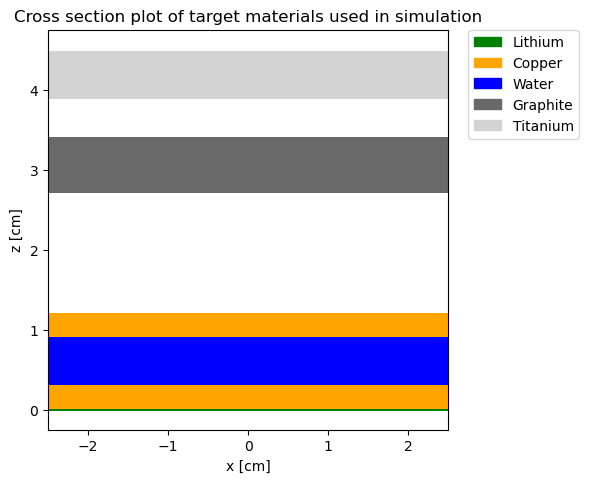

Text(0.5, 1.0, 'Target wheel view along z axis')

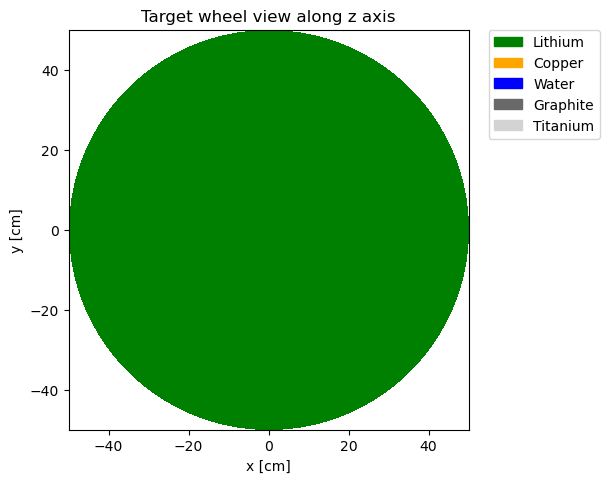

In [16]:
# Define cells
li_cell = openmc.Cell(fill=li7, region = - cylinder & + li_start & - li_end)
cu_cell_1 = openmc.Cell(fill=cu, region = -cylinder & + li_end & - cu_1_end)
water_cell = openmc.Cell(fill=h2o, region = -cylinder & + cu_1_end & - water_end)
cu_cell_2 = openmc.Cell(fill=cu, region = -cylinder & + water_end & - cu_2_end)
vac_cell_1 = openmc.Cell(fill=None, region = -cylinder & + cu_2_end & - vac_1_end)
graphite_cell = openmc.Cell(fill=graphite, region = -cylinder & + vac_1_end & -graph_end)
vac_cell_2 = openmc.Cell(fill=None, region = -cylinder & + graph_end & - vac_2_end)
ti_cell = openmc.Cell(fill=ti, region = -cylinder & + vac_2_end & -ti_end)

wheel_universe = openmc.Universe(cells=[li_cell, cu_cell_1, water_cell, cu_cell_2, vac_cell_1, graphite_cell, vac_cell_2, ti_cell])

wheel_universe.plot((0,0,4.5/2), width=(5, 5), pixels=(400,400), basis='xz', color_by='material', 
                    colors={li7: 'green', cu: 'orange', h2o: 'blue', graphite: 'dimgray', ti: 'lightgray'},
                    legend=True, outline=False)
plt.title('Cross section plot of target materials used in simulation')
plt.show()

wheel_universe.plot((0.0,0,0), width=(100, 100), pixels=(400,400), basis='xy', color_by='material', 
                    colors={li7: 'green', cu: 'orange', h2o: 'blue', graphite: 'dimgray', ti: 'lightgray'},
                    legend=True, outline=False)
plt.title('Target wheel view along z axis')



Place this setup inside a cubic geometry.

In [17]:
# Define surfaces for room geometry
back_wall = openmc.ZPlane(z0=-50, boundary_type='vacuum')
front_wall = openmc.ZPlane(z0=250, boundary_type='vacuum')
left_wall = openmc.XPlane(x0=-150, boundary_type='vacuum')
right_wall = openmc.XPlane(x0=150, boundary_type='vacuum')
floor = openmc.YPlane(y0=-100, boundary_type='vacuum')
ceiling = openmc.YPlane(y0=100,boundary_type='vacuum')

wheel_region = -cylinder & -li_start & +ti_end

# Define room cell


room_cell = openmc.Cell(fill=air, region = +back_wall & -front_wall & +left_wall & -right_wall & +floor & -ceiling & ~wheel_region)
#wheel_universe.add_cell(room_cell)
geometry = openmc.Geometry([room_cell, li_cell, cu_cell_1, cu_cell_2, water_cell, vac_cell_1,  vac_cell_2, graphite_cell, ti_cell])
geometry.export_to_xml()

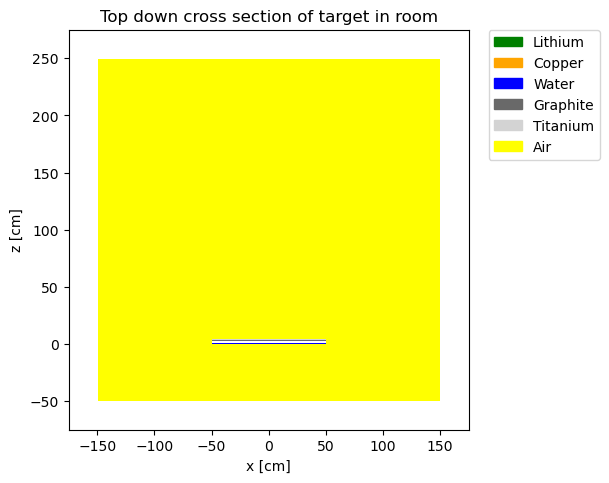

In [18]:
geometry.plot((0,0,100), width=(350, 350), pixels=(400,400), basis='xz', color_by='material', 
                    colors={li7: 'green', cu: 'orange', h2o: 'blue', graphite: 'dimgray', ti: 'lightgray', air: 'yellow'},
                    legend=True, outline=False)
plt.title('Top down cross section of target in room')
plt.show()

Now start the neutrons within a 10cm diameter circle at the centre of the lithium sheet.

For this I will need to adapt the C++ source executable. I have done this and documented it in my notes for wc 11-12-23.

In [19]:
# Define source
Ep = '2.60'
comp_source = openmc.CompiledSource(f'../fuente_LiMetal_Epmin_0_Epmax_{Ep}/build/libsource.so')

# Set up simulation
settings = openmc.Settings()
settings.source = comp_source
settings.particles = 10_000
settings.batches = 10
settings.run_mode = 'fixed source'
settings.max_tracks = 500
settings.export_to_xml()

In [20]:
# Define tallies
tallies = openmc.Tallies()
tallies.export_to_xml()

In [21]:
openmc.run(tracks=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [22]:
#%matplotlib qt
%matplotlib inline
from matplotlib import colormaps

# Define energy colourmap


# Plot tracks
tracks = openmc.Tracks(f'tracks.h5')

energies = []
for t in tracks:
    start = t.particle_tracks[0].states['E'][0]
    #print(start)
    energies.append((start))

#energies = energies.sort()

E_array = np.array(energies)
E_max = np.max(E_array)
print(np.sort(E_array)/E_max)

[0.01130339 0.01249172 0.02019927 0.02290631 0.02486001 0.02787727
 0.03588659 0.03606823 0.03624825 0.0363001  0.03714095 0.03747381
 0.03750406 0.03802005 0.03809985 0.04322219 0.04508223 0.04521534
 0.05032532 0.05071433 0.05077672 0.05376112 0.05920781 0.0635948
 0.06614442 0.06661479 0.06664403 0.06891823 0.07013779 0.07014148
 0.07149256 0.07157328 0.07276343 0.07329293 0.07388752 0.07461059
 0.07576627 0.07656343 0.07827744 0.08525801 0.08855605 0.09075361
 0.09165062 0.09203704 0.09318381 0.09342875 0.09745372 0.09966155
 0.10041979 0.10193888 0.10241739 0.10305796 0.10581302 0.10767725
 0.1088713  0.11154389 0.11185338 0.1190402  0.11906711 0.12219493
 0.1227033  0.12290991 0.12365473 0.12572181 0.12677555 0.12743546
 0.13286247 0.13446986 0.13528637 0.13548323 0.13620783 0.13749375
 0.1392497  0.13989627 0.1400561  0.14080144 0.1416933  0.14238739
 0.14378832 0.14405529 0.14696335 0.14843946 0.14912038 0.14917972
 0.15021524 0.15044218 0.1530911  0.15446336 0.15852311 0.16009

0.027877267998581468
(0.123903, 0.022878, 0.559423, 1.0)
0.4412947444685714
(0.736019, 0.209439, 0.527908, 1.0)
0.8707611936564218
(0.993851, 0.759304, 0.159092, 1.0)
0.12572180642446074
(0.299855, 0.009561, 0.631624, 1.0)
0.08525800660642442
(0.227983, 0.016007, 0.604867, 1.0)
0.49288106092988354
(0.790855, 0.271345, 0.476706, 1.0)
0.4642935430211306
(0.760264, 0.235976, 0.505794, 1.0)
0.5197110870455108
(0.816144, 0.302368, 0.451816, 1.0)
0.17971832766996765
(0.387183, 0.001434, 0.654177, 1.0)
0.35555294160663076
(0.640959, 0.116492, 0.602065, 1.0)
0.3219419863982316
(0.595011, 0.07719, 0.627917, 1.0)
0.19739609482464093
(0.41158, 0.000577, 0.65773, 1.0)
0.7681794072327863
(0.979233, 0.607532, 0.238013, 1.0)
0.39362283603491166
(0.683758, 0.156278, 0.57166, 1.0)
0.2528862141910584
(0.494877, 0.01199, 0.657865, 1.0)
0.6121738947561903
(0.89034, 0.406398, 0.37313, 1.0)
0.10193887789110204
(0.261183, 0.013308, 0.617911, 1.0)
0.2660870423602819
(0.517933, 0.021563, 0.654109, 1.0)
0.32457

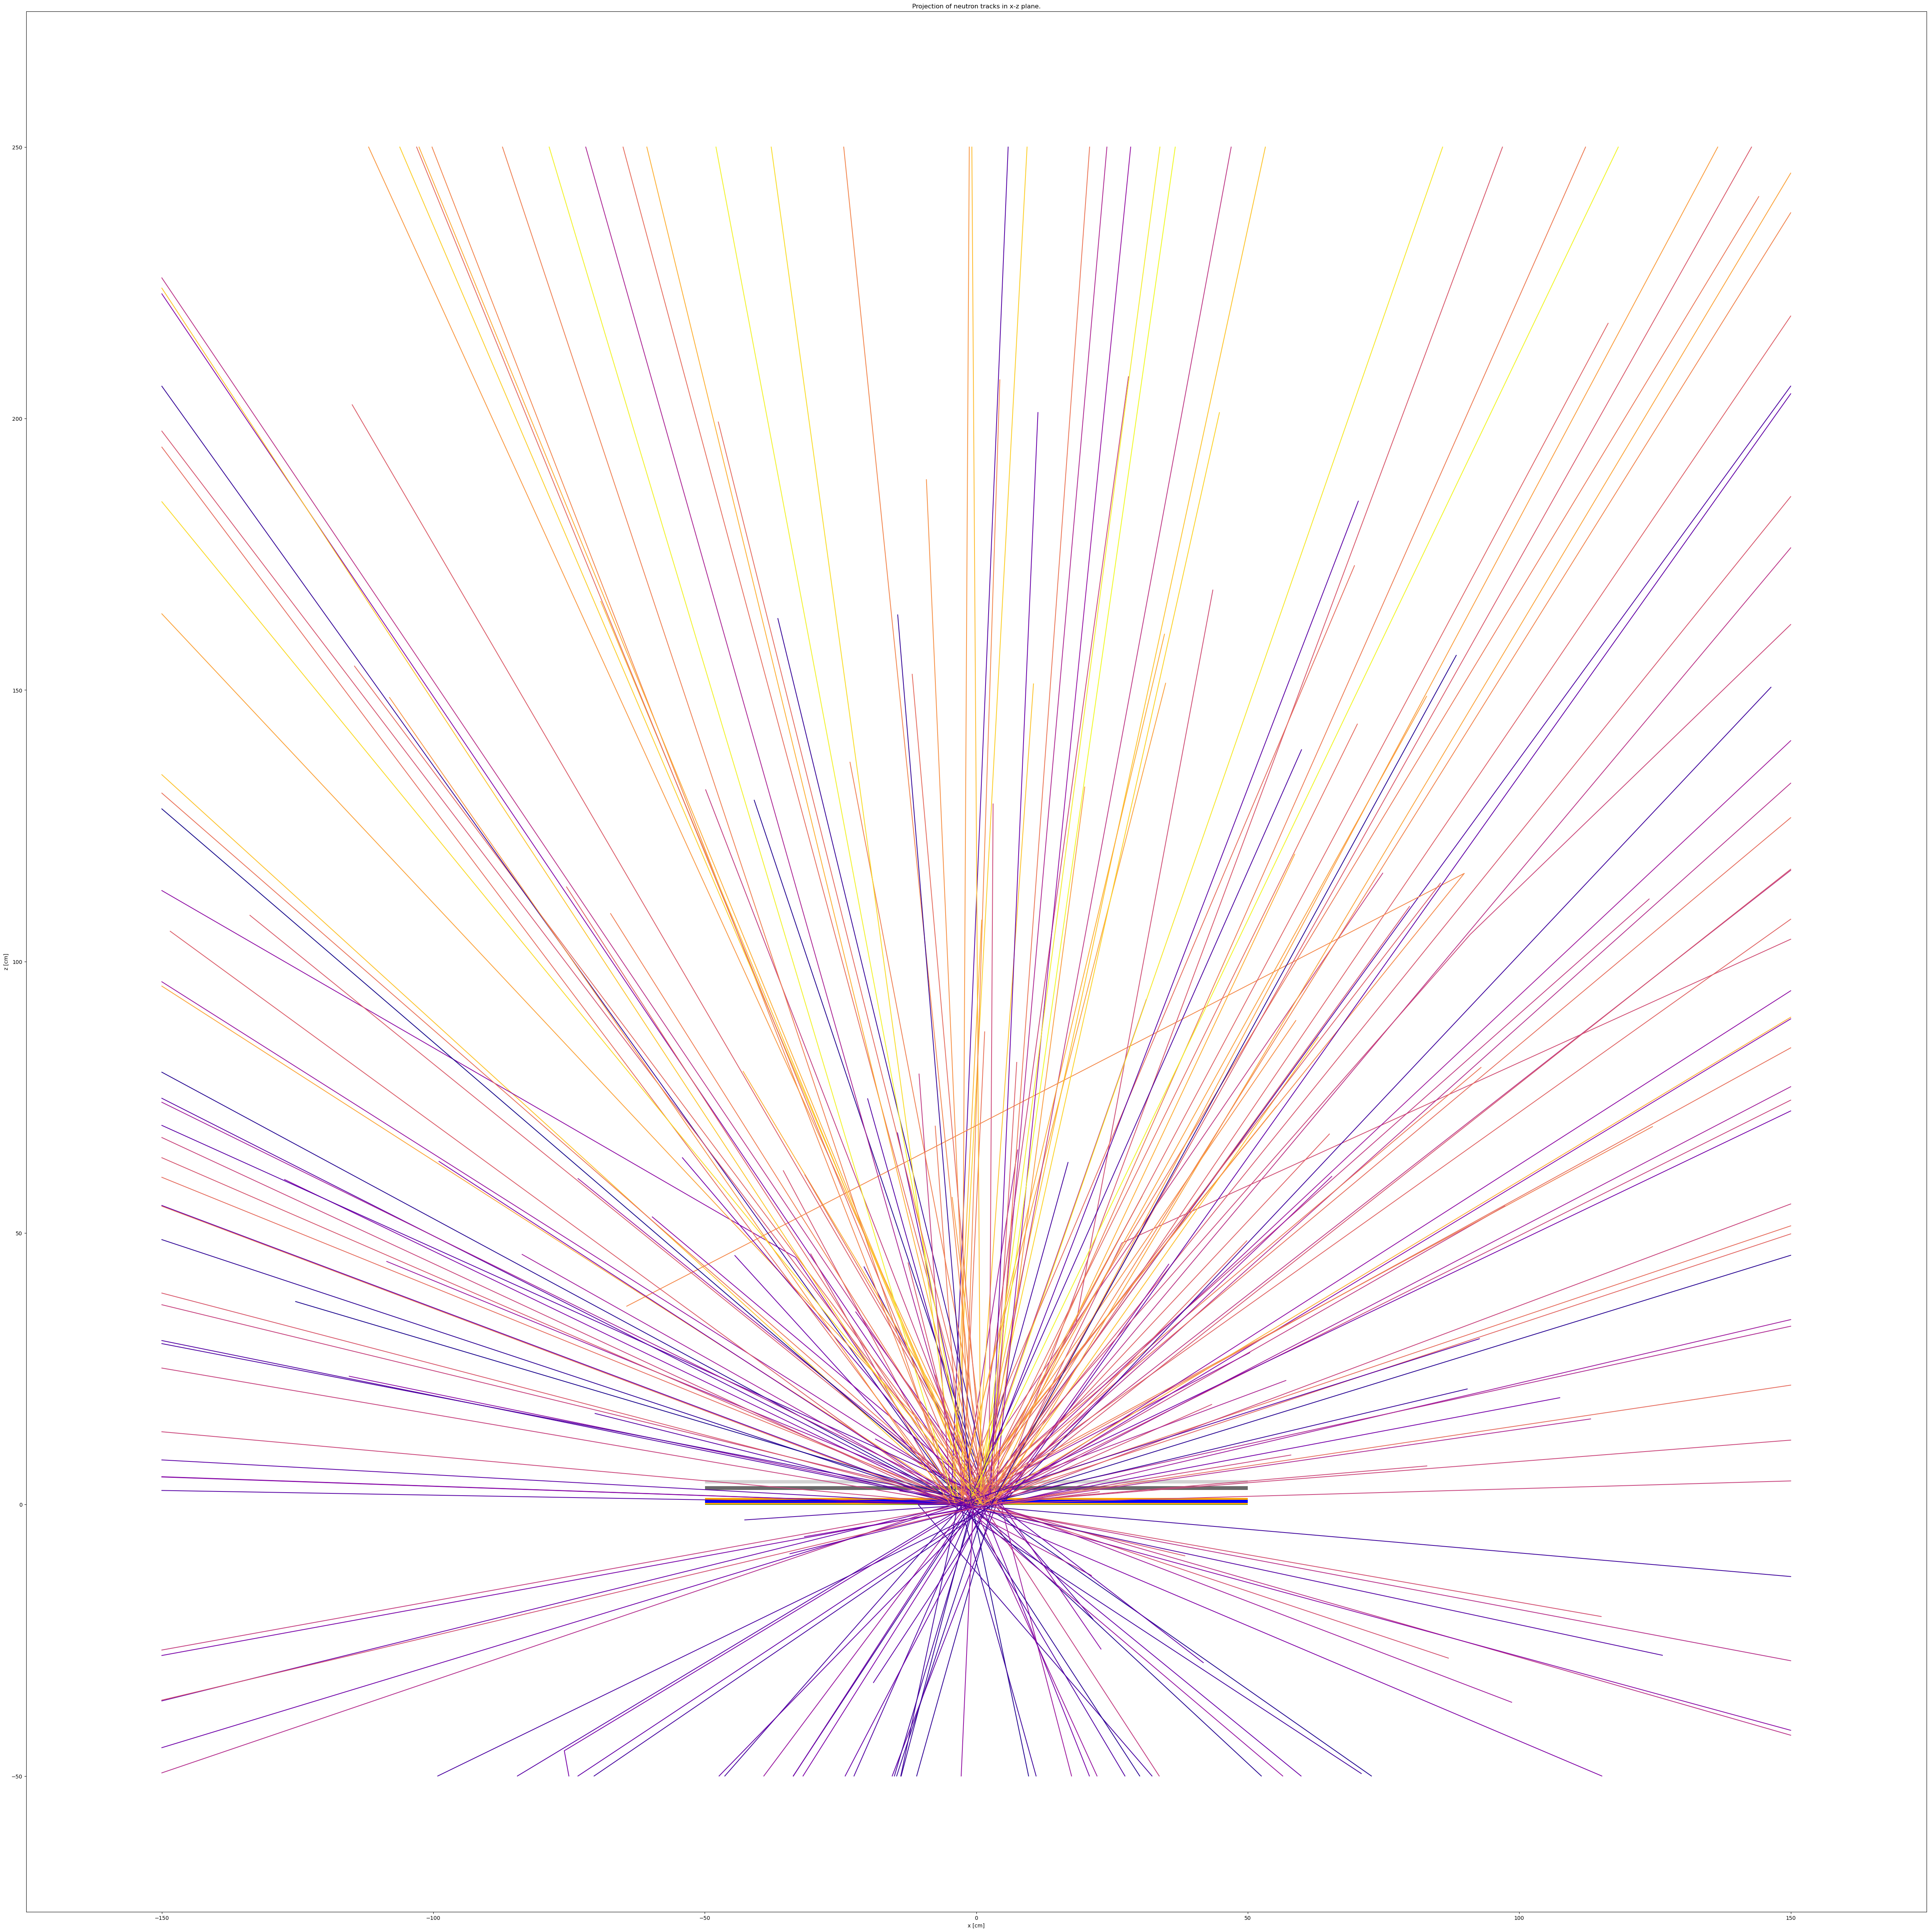

In [23]:
geometry.plot((0,0,100), width=(350, 350), pixels=(5000,5000), basis='xz', color_by='material', 
                    colors={li7: 'green', cu: 'orange', h2o: 'blue', graphite: 'dimgray', ti: 'lightgray', air: 'white'},
                    legend=False, outline=False)

for t in tracks[::2]:

    E = t.particle_tracks[0].states['E'][0]
    c = E/E_max
    print(c)
    c_map = plt.cm.plasma(c)
    print(c_map)
    x = []
    y = []
    z = []
    start = t.particle_tracks[0].states['r']
    for v in start:
        x.append(v[0])
        y.append(v[1])
        z.append(v[2])
    plt.plot(x, z, color=c_map)

#plt.scatter(x, z)
plt.title('Projection of neutron tracks in x-z plane.')
plt.show()

0.027877267998581468
0.5889860910444641
0.4412947444685714
0.460578292409601
0.8707611936564218
0.8425357559466801
0.12572180642446074
0.7756447402566611
0.08525800660642442
0.3350094297638478
0.49288106092988354
0.07329292752162572
0.4642935430211306
0.49002424609080314
0.5197110870455108
0.5876198298680175
0.17971832766996765
0.44947662610573597
0.35555294160663076
0.13446986062284325
0.3219419863982316
0.04508222617414226
0.19739609482464093
0.6364665341769158
0.7681794072327863
0.6766252266878683
0.39362283603491166
0.49938270185181677
0.2528862141910584
0.03802004771491319
0.6121738947561903
0.20888377047972326
0.10193887789110204
0.6721643918976988
0.2660870423602819
0.6266235145162387
0.3245745170341437
0.7858624682278434
0.41511612071808457
0.23897701893100723
0.6384519207417501
0.7000373684787932
0.03630009722583677
0.9328840136041221
0.44802438937946343
0.5470958499302895
0.45879096111933265
0.6540239132972794
0.5318239641067646
0.166474367846159
0.5284318371188673
0.62134782

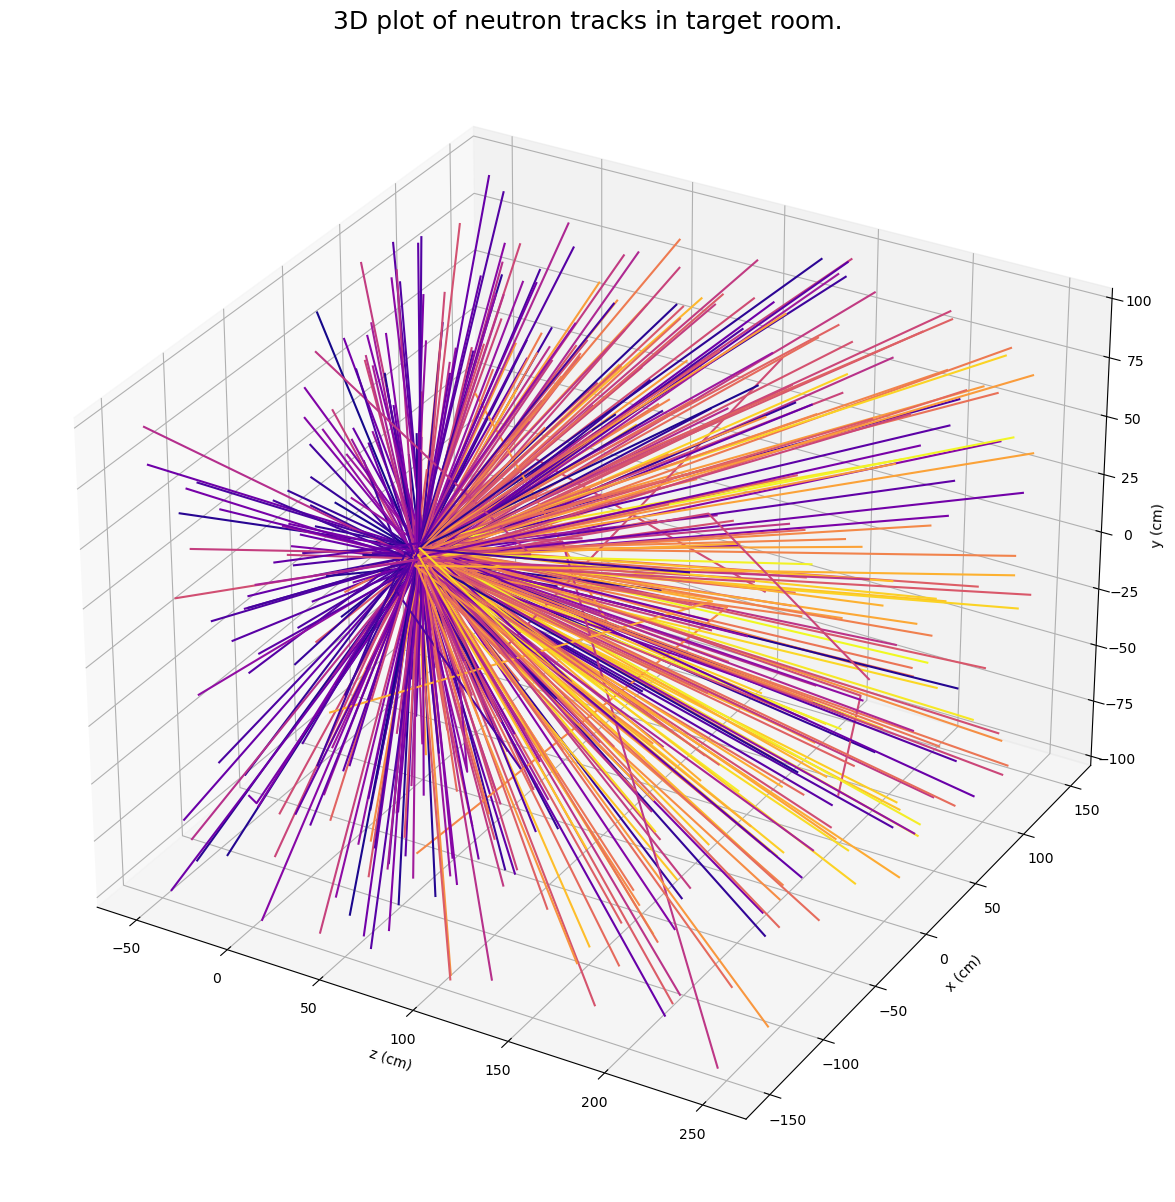

In [25]:
# A 3D version of the above plot
#from mpl_toolkits.mplot3d import Axes3D

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
Xc,Yc,Zc = data_for_cylinder_along_z(0.0,42,50,4.5)
#ax.plot_surface(Zc, Xc, Yc, alpha=0.8)

for t in tracks:
    E = t.particle_tracks[0].states['E'][0]
    c = E/E_max
    print(c)
    c_map = plt.cm.plasma(c)
    x = []
    y = []
    z = []
    start = t.particle_tracks[0].states['r']
    for v in start:
        x.append(v[0])
        y.append(v[1])
        z.append(v[2])
    plt.plot(z, x, y, color=c_map)

#plt.scatter(x, z)
plt.title('3D plot of neutron tracks in target room.', fontsize=18)
ax.set_xlabel('z (cm)')
ax.set_ylabel('x (cm)')
ax.set_zlabel('y (cm)')
plt.show()


500
500


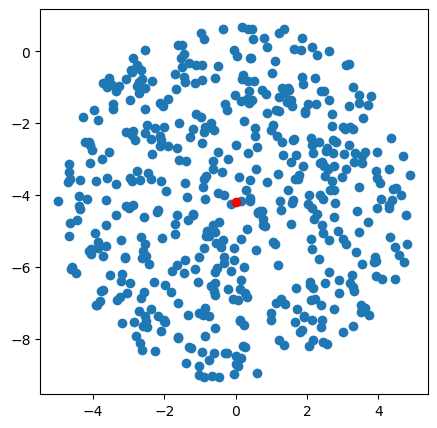

In [26]:
tracks = openmc.Tracks(f'tracks.h5')
x = []
y = []
z = []
print(len(tracks))
for t in tracks:
    start = t.particle_tracks[0].states['r'][0]
    y.append(start[1])
    z.append(start[2])
    x.append(start[0])
print(len(z)) 
fig = plt.figure(figsize=(5,5))
plt.scatter(x, y)
plt.scatter(0, -4.2, color='r')
plt.show()